<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S6/EVAsession6Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

# Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


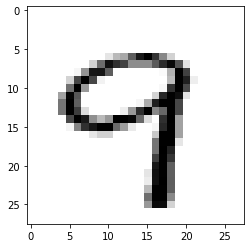

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

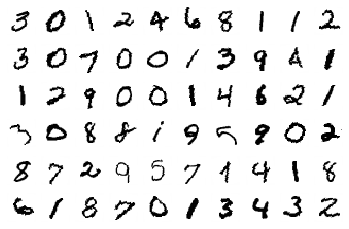

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model

In [0]:
dropout_value = 0.06
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

Viewing model summary is important. There is no in-built model visualizer in pyTorch. take external help from torychsummary.

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
import numpy as np

class ModelTrain():
  def __init__(self):
    #to monitor training and test losses
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    # initialize tracker for minimum validation loss
    self.valid_loss_min = np.Inf # set initial "min" to infinity

  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prep model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)   # forward pass: compute predicted outputs by passing inputs to the model

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if L1lambda is not None:
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1lambda * reg_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])


  ####VAlidate the model ####
  def test(self, model, device, test_loader,filename):
    #valid_loss_min = np.Inf
    model.eval()  # prep model for evaluation
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        self.valid_loss_min,
        test_loss))
        torch.save(model.state_dict(), filename)
        self.valid_loss_min = test_loss


# Let's Train and test our model
## Model without L1 and L2 regularizations

In [10]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#first model
#without L1 and L2 regularization
model00 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model00.train(model, device, train_loader, optimizer, epoch, scheduler)
    model00.test(model, device, test_loader,"model00.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09668759256601334 Batch_id=468 Accuracy=80.03: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9766/10000 (97.66%)

Validation loss decreased (inf --> 0.091075).  Saving model ...
EPOCH: 1


Loss=0.09516660124063492 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:20<00:00, 25.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9740/10000 (97.40%)

Validation loss decreased (0.091075 --> 0.083775).  Saving model ...
EPOCH: 2


Loss=0.07750486582517624 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:20<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9874/10000 (98.74%)

Validation loss decreased (0.083775 --> 0.040979).  Saving model ...
EPOCH: 3


Loss=0.07742554694414139 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:19<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9873/10000 (98.73%)

Validation loss decreased (0.040979 --> 0.039305).  Saving model ...
EPOCH: 4


Loss=0.09359440952539444 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.07265464216470718 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)

Validation loss decreased (0.039305 --> 0.031022).  Saving model ...
EPOCH: 6


Loss=0.06174232065677643 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.024262020364403725 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:19<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

Validation loss decreased (0.031022 --> 0.026771).  Saving model ...
EPOCH: 8


Loss=0.06576769053936005 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.05094840005040169 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

Validation loss decreased (0.026771 --> 0.025409).  Saving model ...
EPOCH: 10


Loss=0.046690452843904495 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

Validation loss decreased (0.025409 --> 0.023594).  Saving model ...
EPOCH: 11


Loss=0.08138696849346161 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

Validation loss decreased (0.023594 --> 0.023268).  Saving model ...
EPOCH: 12


Loss=0.02758702076971531 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.0214542243629694 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.052020687609910965 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

Validation loss decreased (0.023268 --> 0.022074).  Saving model ...
EPOCH: 15


Loss=0.009381149895489216 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.04042400047183037 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

Validation loss decreased (0.022074 --> 0.021647).  Saving model ...
EPOCH: 17


Loss=0.1185554638504982 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9927/10000 (99.27%)

Validation loss decreased (0.021647 --> 0.020987).  Saving model ...
EPOCH: 18


Loss=0.003130977274850011 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

Validation loss decreased (0.020987 --> 0.020344).  Saving model ...
EPOCH: 19


Loss=0.03389881178736687 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.020344 --> 0.019419).  Saving model ...
EPOCH: 20


Loss=0.019449507817626 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.019419 --> 0.019389).  Saving model ...
EPOCH: 21


Loss=0.0010178983211517334 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

Validation loss decreased (0.019389 --> 0.017048).  Saving model ...
EPOCH: 22


Loss=0.009283741004765034 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.027207186445593834 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.001828700304031372 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.024761846289038658 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)

Validation loss decreased (0.017048 --> 0.016345).  Saving model ...
EPOCH: 26


Loss=0.0364227294921875 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9951/10000 (99.51%)

EPOCH: 27


Loss=0.06399146467447281 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

Validation loss decreased (0.016345 --> 0.016266).  Saving model ...
EPOCH: 28


Loss=0.09028172492980957 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.009818504564464092 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Loss=0.033611103892326355 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9953/10000 (99.53%)

EPOCH: 31


Loss=0.007693191524595022 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.016266 --> 0.015593).  Saving model ...
EPOCH: 32


Loss=0.011377240531146526 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9951/10000 (99.51%)

EPOCH: 33


Loss=0.027144810184836388 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9949/10000 (99.49%)

EPOCH: 34


Loss=0.10282745212316513 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9951/10000 (99.51%)

Validation loss decreased (0.015593 --> 0.015505).  Saving model ...
EPOCH: 35


Loss=0.05361362174153328 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9958/10000 (99.58%)

Validation loss decreased (0.015505 --> 0.015265).  Saving model ...
EPOCH: 36


Loss=0.0031806379556655884 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9959/10000 (99.59%)

Validation loss decreased (0.015265 --> 0.014869).  Saving model ...
EPOCH: 37


Loss=0.009863858111202717 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9962/10000 (99.62%)

Validation loss decreased (0.014869 --> 0.014794).  Saving model ...
EPOCH: 38


Loss=0.002177218673750758 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9960/10000 (99.60%)

Validation loss decreased (0.014794 --> 0.014758).  Saving model ...
EPOCH: 39


Loss=0.010176564566791058 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0145, Accuracy: 9961/10000 (99.61%)

Validation loss decreased (0.014758 --> 0.014495).  Saving model ...


# Model with L1 Regualrization

In [11]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#first model
#with L1 regularization
model01 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model01.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model01.test(model, device, test_loader,"model01.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16938969492912292 Batch_id=468 Accuracy=81.08: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1721, Accuracy: 9502/10000 (95.02%)

Validation loss decreased (inf --> 0.172064).  Saving model ...
EPOCH: 1


Loss=0.09278908371925354 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9824/10000 (98.24%)

Validation loss decreased (0.172064 --> 0.058095).  Saving model ...
EPOCH: 2


Loss=0.06623780727386475 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9859/10000 (98.59%)

Validation loss decreased (0.058095 --> 0.048281).  Saving model ...
EPOCH: 3


Loss=0.09068191051483154 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9886/10000 (98.86%)

Validation loss decreased (0.048281 --> 0.038932).  Saving model ...
EPOCH: 4


Loss=0.12032394856214523 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9812/10000 (98.12%)

EPOCH: 5


Loss=0.11949282884597778 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.1462622880935669 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9911/10000 (99.11%)

Validation loss decreased (0.038932 --> 0.030339).  Saving model ...
EPOCH: 7


Loss=0.04190855100750923 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.11338403075933456 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

Validation loss decreased (0.030339 --> 0.025233).  Saving model ...
EPOCH: 9


Loss=0.043053366243839264 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.06839712709188461 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.0467434898018837 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.08272160589694977 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.13428209722042084 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:21<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.05781720206141472 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

Validation loss decreased (0.025233 --> 0.023296).  Saving model ...
EPOCH: 15


Loss=0.049759525805711746 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

Validation loss decreased (0.023296 --> 0.021560).  Saving model ...
EPOCH: 16


Loss=0.057601094245910645 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.04992980509996414 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.020236311480402946 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

Validation loss decreased (0.021560 --> 0.020748).  Saving model ...
EPOCH: 19


Loss=0.027012376114726067 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.040050819516181946 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.039710935205221176 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.120359867811203 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.03677365928888321 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.020748 --> 0.020647).  Saving model ...
EPOCH: 24


Loss=0.016243595629930496 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

Validation loss decreased (0.020647 --> 0.020604).  Saving model ...
EPOCH: 25


Loss=0.035911574959754944 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.020604 --> 0.016788).  Saving model ...
EPOCH: 26


Loss=0.06865788996219635 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9958/10000 (99.58%)

EPOCH: 27


Loss=0.030916254967451096 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.016788 --> 0.016159).  Saving model ...
EPOCH: 28


Loss=0.018702328205108643 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 29


Loss=0.04277363419532776 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Loss=0.048373982310295105 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 31


Loss=0.056678611785173416 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9956/10000 (99.56%)

EPOCH: 32


Loss=0.02189304307103157 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9950/10000 (99.50%)

EPOCH: 33


Loss=0.07345805317163467 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9953/10000 (99.53%)

EPOCH: 34


Loss=0.06018524989485741 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9957/10000 (99.57%)

Validation loss decreased (0.016159 --> 0.015376).  Saving model ...
EPOCH: 35


Loss=0.03433612734079361 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9952/10000 (99.52%)

EPOCH: 36


Loss=0.015287769958376884 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

Validation loss decreased (0.015376 --> 0.015325).  Saving model ...
EPOCH: 37


Loss=0.018236154690384865 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9958/10000 (99.58%)

Validation loss decreased (0.015325 --> 0.014994).  Saving model ...
EPOCH: 38


Loss=0.025982290506362915 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9956/10000 (99.56%)

EPOCH: 39


Loss=0.03512910008430481 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0147, Accuracy: 9958/10000 (99.58%)

Validation loss decreased (0.014994 --> 0.014674).  Saving model ...


# Model with L2 Regularization

In [12]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#first model
#without L1 and L2 regularization
model10 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model10.train(model, device, train_loader, optimizer, epoch, scheduler)
    model10.test(model, device, test_loader,"model10.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13396447896957397 Batch_id=468 Accuracy=75.89: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0972, Accuracy: 9737/10000 (97.37%)

Validation loss decreased (inf --> 0.097243).  Saving model ...
EPOCH: 1


Loss=0.14419852197170258 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9846/10000 (98.46%)

Validation loss decreased (0.097243 --> 0.052980).  Saving model ...
EPOCH: 2


Loss=0.06640172749757767 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9862/10000 (98.62%)

Validation loss decreased (0.052980 --> 0.047511).  Saving model ...
EPOCH: 3


Loss=0.13737128674983978 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9881/10000 (98.81%)

Validation loss decreased (0.047511 --> 0.035770).  Saving model ...
EPOCH: 4


Loss=0.06870372593402863 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9905/10000 (99.05%)

Validation loss decreased (0.035770 --> 0.032516).  Saving model ...
EPOCH: 5


Loss=0.025488322600722313 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.10351989418268204 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.02469484508037567 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

Validation loss decreased (0.032516 --> 0.024712).  Saving model ...
EPOCH: 8


Loss=0.023198306560516357 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.03468228504061699 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.02291380800306797 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.037483688443899155 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.058295611292123795 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

Validation loss decreased (0.024712 --> 0.022986).  Saving model ...
EPOCH: 13


Loss=0.012141580693423748 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.15616320073604584 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.03132754564285278 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:20<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.01265003252774477 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:19<00:00, 26.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

Validation loss decreased (0.022986 --> 0.021144).  Saving model ...
EPOCH: 17


Loss=0.07155344635248184 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.00950584840029478 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.010529075749218464 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.03271884843707085 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

EPOCH: 21


Loss=0.016098355874419212 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:19<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.021144 --> 0.017518).  Saving model ...
EPOCH: 22


Loss=0.008740107528865337 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.04801604524254799 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.04071446880698204 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.05467117205262184 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.0345258004963398 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:19<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Loss=0.021534308791160583 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.017518 --> 0.017175).  Saving model ...
EPOCH: 28


Loss=0.014669135212898254 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.015073333866894245 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.013562515377998352 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.011681740172207355 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.019990378990769386 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.05021155998110771 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 34


Loss=0.030493399128317833 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.017175 --> 0.015244).  Saving model ...
EPOCH: 35


Loss=0.007449403405189514 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9944/10000 (99.44%)

EPOCH: 36


Loss=0.018725475296378136 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 9945/10000 (99.45%)

Validation loss decreased (0.015244 --> 0.014439).  Saving model ...
EPOCH: 37


Loss=0.029659973457455635 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9951/10000 (99.51%)

Validation loss decreased (0.014439 --> 0.014348).  Saving model ...
EPOCH: 38


Loss=0.007826055400073528 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 9951/10000 (99.51%)

EPOCH: 39


Loss=0.004756217356771231 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]



Test set: Average loss: 0.0136, Accuracy: 9954/10000 (99.54%)

Validation loss decreased (0.014348 --> 0.013564).  Saving model ...


# Model with L1 and L2 regularization 

In [13]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#first model
#without L1 and L2 regularization
model11 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model11.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model11.test(model, device, test_loader,"model11.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.273811399936676 Batch_id=468 Accuracy=81.93: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1238, Accuracy: 9673/10000 (96.73%)

Validation loss decreased (inf --> 0.123822).  Saving model ...
EPOCH: 1


Loss=0.056617140769958496 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0646, Accuracy: 9811/10000 (98.11%)

Validation loss decreased (0.123822 --> 0.064637).  Saving model ...
EPOCH: 2


Loss=0.11261332780122757 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9830/10000 (98.30%)

Validation loss decreased (0.064637 --> 0.051528).  Saving model ...
EPOCH: 3


Loss=0.019819041714072227 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9867/10000 (98.67%)

Validation loss decreased (0.051528 --> 0.044301).  Saving model ...
EPOCH: 4


Loss=0.023792842403054237 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9893/10000 (98.93%)

Validation loss decreased (0.044301 --> 0.035959).  Saving model ...
EPOCH: 5


Loss=0.12205826491117477 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9911/10000 (99.11%)

Validation loss decreased (0.035959 --> 0.031573).  Saving model ...
EPOCH: 6


Loss=0.06218449026346207 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.1284937709569931 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.06718409806489944 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9911/10000 (99.11%)

Validation loss decreased (0.031573 --> 0.029655).  Saving model ...
EPOCH: 9


Loss=0.06438535451889038 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 27.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.022398855537176132 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.042122989892959595 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

Validation loss decreased (0.029655 --> 0.026849).  Saving model ...
EPOCH: 12


Loss=0.0451357364654541 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

Validation loss decreased (0.026849 --> 0.025576).  Saving model ...
EPOCH: 13


Loss=0.06322050094604492 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.08040429651737213 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

Validation loss decreased (0.025576 --> 0.023531).  Saving model ...
EPOCH: 15


Loss=0.02198747545480728 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.03582356497645378 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9869/10000 (98.69%)

EPOCH: 17


Loss=0.0707387775182724 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 18


Loss=0.024675684049725533 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9943/10000 (99.43%)

Validation loss decreased (0.023531 --> 0.023348).  Saving model ...
EPOCH: 19


Loss=0.01629721000790596 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Loss=0.06974814087152481 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

Validation loss decreased (0.023348 --> 0.022358).  Saving model ...
EPOCH: 21


Loss=0.0381624698638916 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.041600167751312256 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.09467703104019165 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:21<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.022358 --> 0.021703).  Saving model ...
EPOCH: 24


Loss=0.025610361248254776 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 21.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

Validation loss decreased (0.021703 --> 0.021460).  Saving model ...
EPOCH: 25


Loss=0.032378435134887695 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 26


Loss=0.19198136031627655 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:21<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.046358052641153336 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.02639860101044178 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.021460 --> 0.018520).  Saving model ...
EPOCH: 29


Loss=0.02445906214416027 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 30


Loss=0.0259660966694355 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.0933588519692421 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


Loss=0.11038848757743835 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.01714206673204899 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

Validation loss decreased (0.018520 --> 0.016451).  Saving model ...
EPOCH: 34


Loss=0.03555130958557129 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 35


Loss=0.02273164875805378 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 36


Loss=0.01979985646903515 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.03992999717593193 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9950/10000 (99.50%)

Validation loss decreased (0.016451 --> 0.016239).  Saving model ...
EPOCH: 38


Loss=0.02648138254880905 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.016239 --> 0.015468).  Saving model ...
EPOCH: 39


Loss=0.039645034819841385 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 29.66it/s]



Test set: Average loss: 0.0155, Accuracy: 9954/10000 (99.54%)



# Graphs

In [14]:
#dir(model00)
print(len(model00.train_epoch_end), model00.train_epoch_end)
print(len(model01.train_epoch_end), model01.train_epoch_end)
print(len(model10.train_epoch_end), model10.train_epoch_end)
print(len(model11.train_epoch_end), model11.train_epoch_end)

40 [80.02666666666667, 96.69666666666667, 97.39166666666667, 97.70666666666666, 97.97166666666666, 98.12, 98.235, 98.29666666666667, 98.37333333333333, 98.42833333333333, 98.585, 98.47333333333333, 98.60166666666667, 98.61666666666666, 98.725, 98.77, 98.71333333333334, 98.79, 98.87166666666667, 98.855, 98.96, 98.86, 98.95333333333333, 98.93166666666667, 98.96, 98.98, 99.055, 98.99833333333333, 99.01333333333334, 99.10666666666667, 99.06833333333333, 99.115, 99.19166666666666, 99.19, 99.17, 99.22166666666666, 99.245, 99.23333333333333, 99.26, 99.28666666666666]
40 [81.08333333333333, 96.83333333333333, 97.35, 97.55833333333334, 97.855, 98.04833333333333, 98.14666666666666, 98.22, 98.27833333333334, 98.41, 98.45166666666667, 98.43666666666667, 98.54666666666667, 98.555, 98.635, 98.7, 98.745, 98.76166666666667, 98.73166666666667, 98.765, 98.76833333333333, 98.81333333333333, 98.86666666666666, 98.90833333333333, 98.89166666666667, 98.89, 98.93666666666667, 98.92333333333333, 99.035, 98.98

## Plotting Validation Accuracy of 4 Models

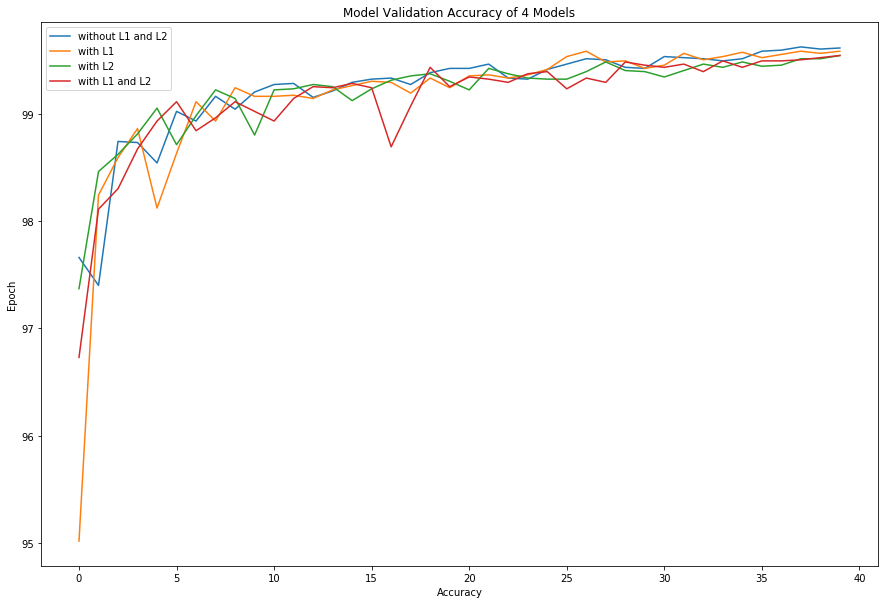

In [27]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model00.test_acc)
ax.plot(model01.test_acc)
ax.plot(model10.test_acc)
ax.plot(model11.test_acc)
ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4models.png")
plt.show()


## Plotting Validation Loss of Four Models

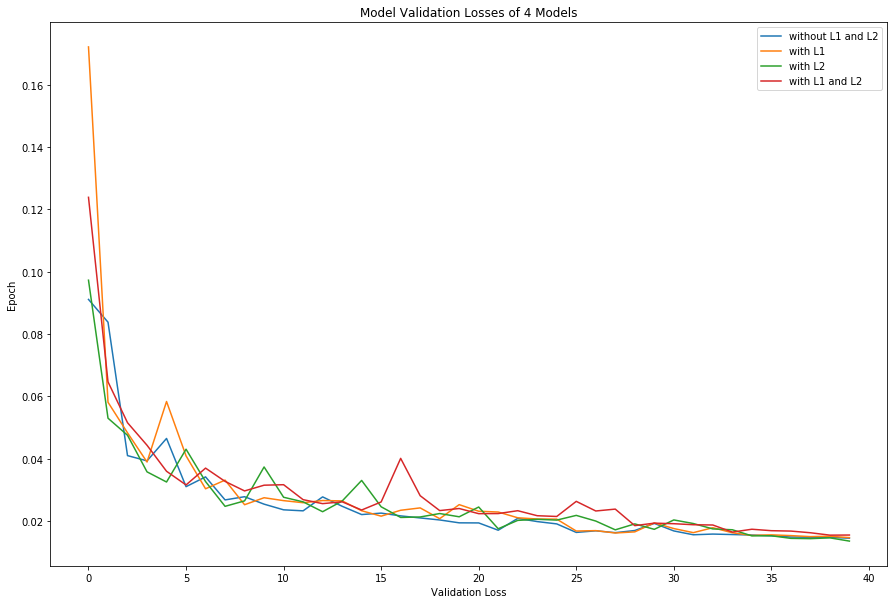

In [33]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model00.test_losses)
ax.plot(model01.test_losses)
ax.plot(model10.test_losses)
ax.plot(model11.test_losses)
ax.set(title="Model Validation Losses of 4 Models", xlabel="Validation Loss", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("ValidationLossof4models.png")
plt.show()


## Function to plot Misclassified images

In [0]:
def PlotMisclassifiedImages(model, filename):
  
  model = model.to(device)
  # obtain one batch of test images
  dataiter = iter(test_loader)
  c=0
  fig = plt.figure(figsize=(14,14 ))
  
  while c<25:
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)  # get sample outputs

    _, preds = torch.max(output, 1)   # convert output probabilities to predicted class
    images = images.cpu().numpy() # prep images for display
    
    for idx in np.arange(128):
      if preds[idx]!=labels[idx] :
        ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
        c=c+1
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("P-{} (T-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
        if c==25:
          break
    plt.savefig(filename)

----Misclassified images by a Model without L1 and L2 regualatization----


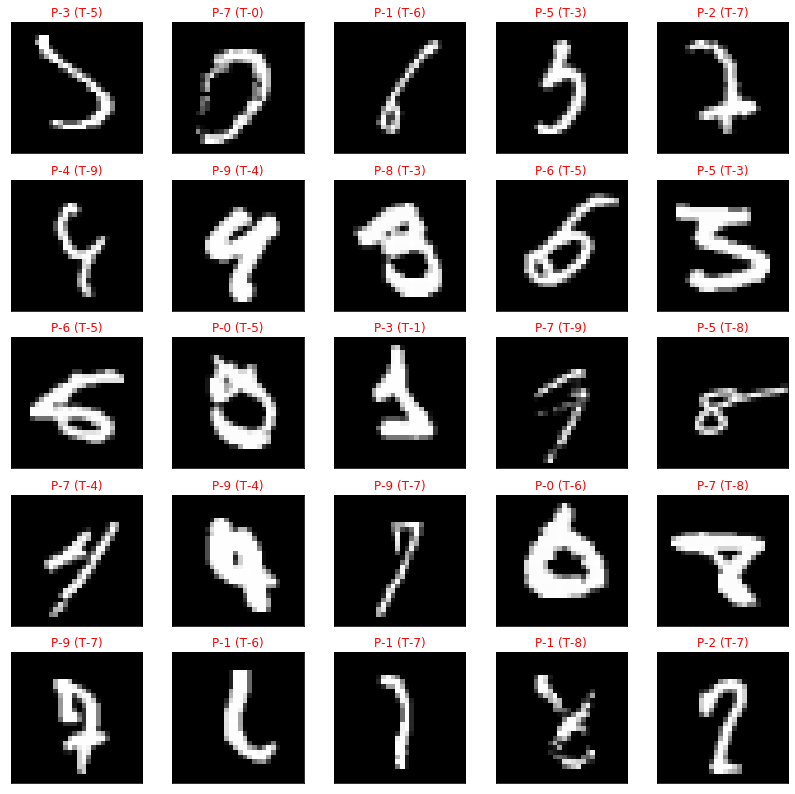

In [18]:
#Load the first model with lowest validation loss
print("----Misclassified images by a Model without L1 and L2 regualatization----")
model.load_state_dict(torch.load("model00.pt")) 
PlotMisclassifiedImages(model, filename="WithoutL1andL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 regualatization----


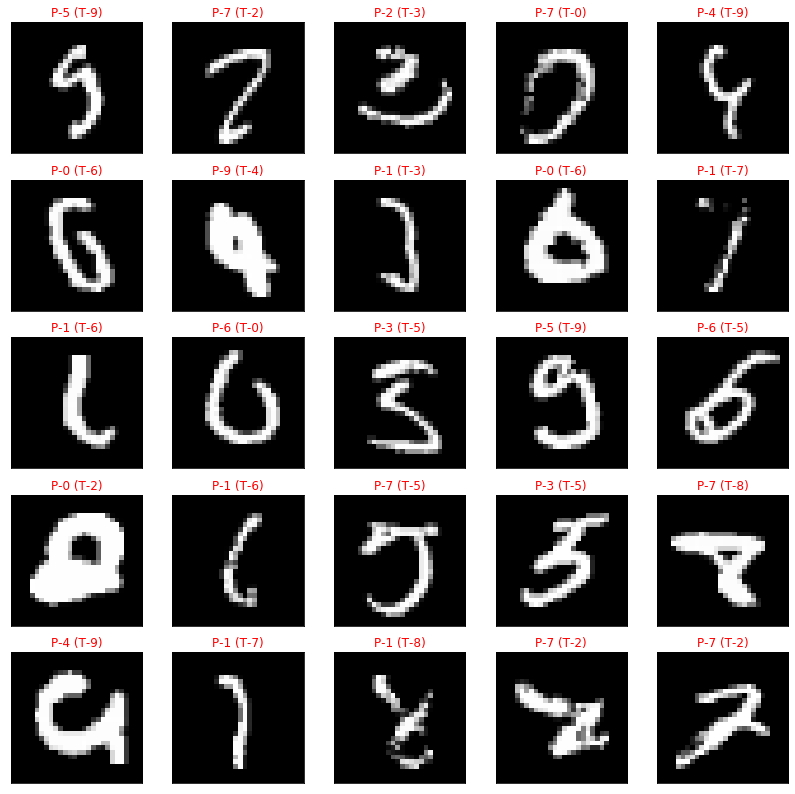

In [19]:
#Load the second model with lowest validation loss
print("----Misclassified images by a Model with L1 regualatization----")
model.load_state_dict(torch.load("model01.pt")) 
PlotMisclassifiedImages(model, filename="WithL1.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L2 regualatization----


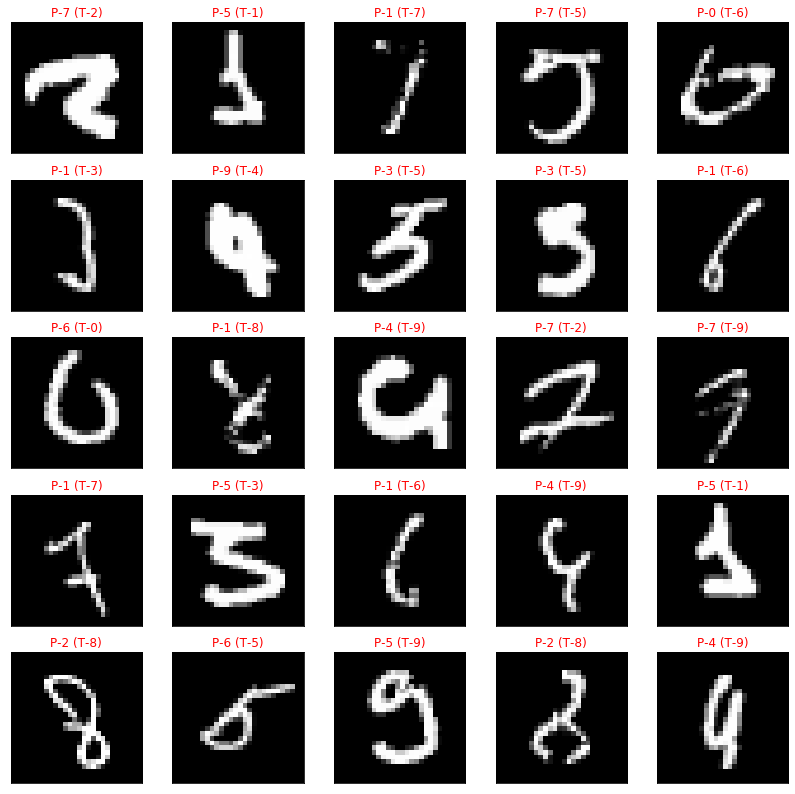

In [20]:
#Load the third model with lowest validation loss
print("----Misclassified images by a Model with L2 regualatization----")
model.load_state_dict(torch.load("model10.pt")) 
PlotMisclassifiedImages(model, filename="WithL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 and L2 regualatization----


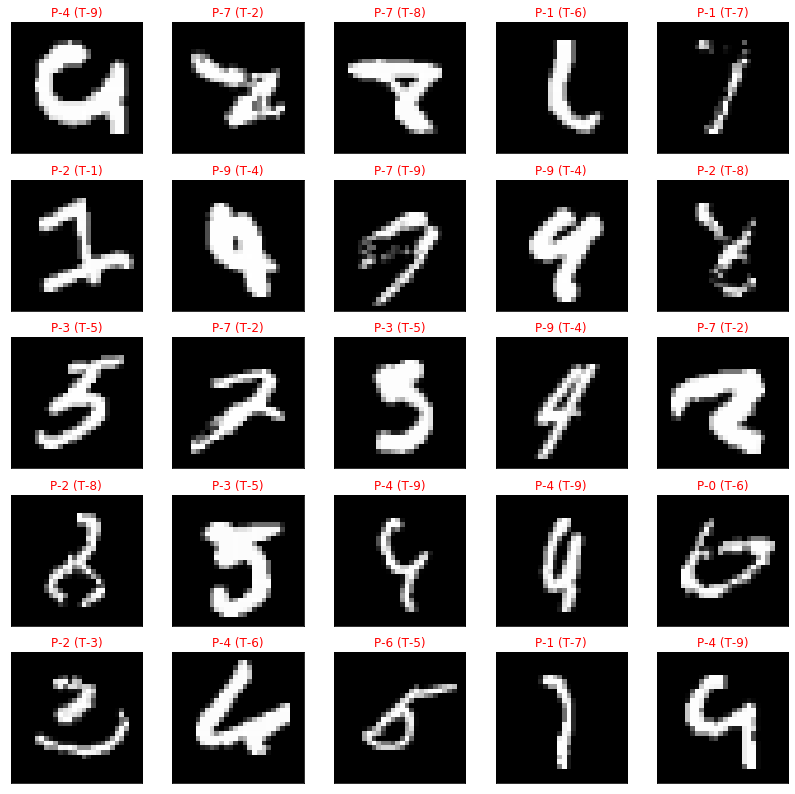

In [21]:
#Load the Fourth model with lowest validation loss
print("----Misclassified images by a Model with L1 and L2 regualatization----")
model.load_state_dict(torch.load("model11.pt")) 
PlotMisclassifiedImages(model, filename="WithL1andL2.png")  #25 misclassified images and save it in a file.